## Read me

This project uses PRAW (Python Reddit API Wrapper), which requires Reddit OAuth2 credentials to function properly.
The results shown below were generated using my personal Reddit account, with the API key and secret redacted for privacy reasons.
If you are interested in testing the notebook, please refer to Reddit’s OAuth2 Quick Start Guide (https://github.com/reddit-archive/reddit/wiki/OAuth2) to create your own API credentials and get started.


In [ ]:
import praw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Web Scraping

## Scraping Reddit Posts with Praw

In [ ]:
# Initiating praw
reddit = praw.Reddit(user_agent_= True,
                    client_id = '',   # Fill in Reddit API keys for scraping
                    client_secret = "",
                    user_agent = "",  
)

# Selecting Subreddit
subreddit = reddit.subreddit("pettyrevenge")

# Creating the list for storage
title = []
body = []
url = []

# Appending the array
for post in subreddit.hot(limit = 100):
    title.append(post.title),
    body.append(post.selftext),
    url.append(post.url)
    
# Creating a df to store scrapped data
df = pd.DataFrame({
    'title': title,
    'body': body,
    'url': url
})

# Saving the results to csv
df.to_csv('scrap_result_praw.csv', index = False)


# Text Analysis

## 2.1 - Sentiment Analysis with Sentiment Intensity Analyzer

In [10]:
# Initiate the analyzer
sentiment = SentimentIntensityAnalyzer()

# Creating an empty list for storage
neg = []
neu = []
pos = []
comp = []

# Performing text analysis on all reddit posts
for post in df['body'].values:
    # Text analysis using Vader
    scores = sentiment.polarity_scores(post)
    
    # Appending the scores
    neg.append(scores['neg'])
    neu.append(scores['neu'])
    pos.append(scores['pos'])
    comp.append(scores['compound'])

# Appending the scores to the df
# df['neg'] = neg
# df['neu'] = neu
# df['pos'] = pos
df['sentiment_score'] = comp

In [11]:
# Inspecting the range of sentiment score
print(f'The highest sentiment score (positive sentiment) is: {df['sentiment_score'].max()}')
print(f'The lowest sentiment score (negative sentiment) is: {df['sentiment_score'].min()}')

# Inspect the range of the score
range = df['sentiment_score'].max() - df['sentiment_score'].min()
print(f'The range of the score is {range:.2f}')


The highest sentiment score (positive sentiment) is: 0.9995
The lowest sentiment score (negative sentiment) is: -0.994
The range of the score is 1.99


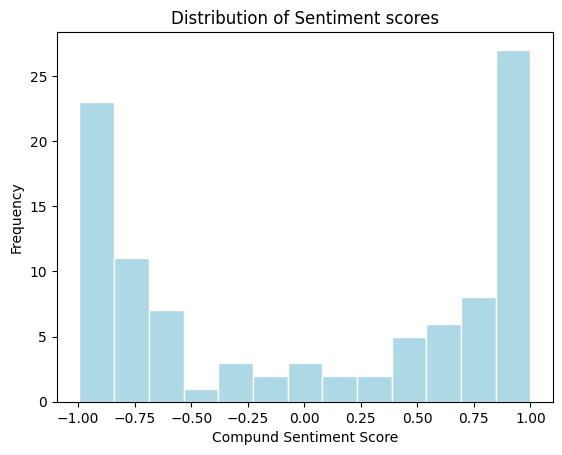

In [12]:
# Visualizing the distribution
plt.hist(df['sentiment_score'], color = 'lightblue', edgecolor = 'white', 
         bins = int(range/0.15))

# Adding labels to the graph
plt.title('Distribution of Sentiment scores')
plt.xlabel('Compund Sentiment Score')
plt.ylabel('Frequency')

plt.show()

## 2.2 - Word Importance Analysis with Scikit-Learn TF-IDF

In [13]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 2, max_df = 0.8)

# Fit and transform the document
tfidf_matrix = vectorizer.fit_transform(df['body'])

# Convert the matrix to a DataFrame for readability:
df_tfidf = pd.DataFrame(tfidf_matrix.todense(), 
                        columns = vectorizer.get_feature_names_out())

# Determining the dimentions
df_tfidf.shape

(100, 1562)

In [14]:
# Getting the total number of non zero columns
non_zero_col = (df_tfidf != 0).sum(axis = 1)

# Calculating the compound TF-IDF scores
tfidf_total = df_tfidf.sum(axis = 1)
avg_tfidf = tfidf_total / non_zero_col

# Adding the scores to the df
df['avg_tfidf'] = avg_tfidf

# Inspecting df
df.head()


,title,body,sentiment_score,avg_tfidf
0,MIL kept guilt tripping me for not eating her ...,My Indian mother-in-law thinks that she is the...,-0.7015,0.097612
1,Xmas three thieves : pettyrevenge,"Not my story, an old neighbor from a few house...",-0.5956,0.126103
2,Dogs off the lawn please : pettyrevenge,The post about the fast food on the lawn remin...,0.6908,0.124188
3,No more fast food litter on my lawn : pettyrev...,This was the pettiest of petty revenges but it...,0.8093,0.120452
4,Spread rumors? I can do a whole lot worse. : p...,So for a little context before I get to the re...,-0.9912,0.062070


## 2.3 - Text Summarization

In [15]:
# Load the model and tokenizer
model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [16]:
# Method to summarize text
def summarize(text):
    # Tokenization
    inputs = tokenizer.encode(
        "summarize: " + text, 
        return_tensors = "pt", 
        max_length = 512,  
        truncation = True
    )
    
    # Generation
    summary_ids = model.generate(
        inputs,
        max_length = 200,         # Output summary length
        min_length = 70,          # Ensures enough content
        length_penalty = 1.2,     # Mild penalty
        num_beams = 6,            # Better quality
        early_stopping = False    # Let model decide when to stop
    )
    
    # Decode
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens = True)
    return summary


In [17]:
# Empty array for appending
summaries = []

# Process every post
for post in df['body']:
    summaries.append(summarize(post))

# Adding to the df
df['summary'] = summaries

# Inspect df
df.head()

# Saving the result to csv
df.to_csv('final_result.csv')